In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
notebook_path = os.path.abspath(os.path.join(os.getcwd(), '../notebooks'))
input_file_path = rf'{notebook_path}\data\processed'

Accuracy: 0.5196145905024088

Confusion Matrix:
 [[319 385]
 [313 436]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.45      0.48       704
           1       0.53      0.58      0.56       749

    accuracy                           0.52      1453
   macro avg       0.52      0.52      0.52      1453
weighted avg       0.52      0.52      0.52      1453


Feature Importance:
 lag_2                0.241811
lag_1                0.235153
lag_3                0.199367
ticks_moved          0.180580
ticks_moved_lag_1    0.143088
dtype: float32


c:\Users\mmori\Documents\fx_strategy_project\fx_strategy_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:59:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


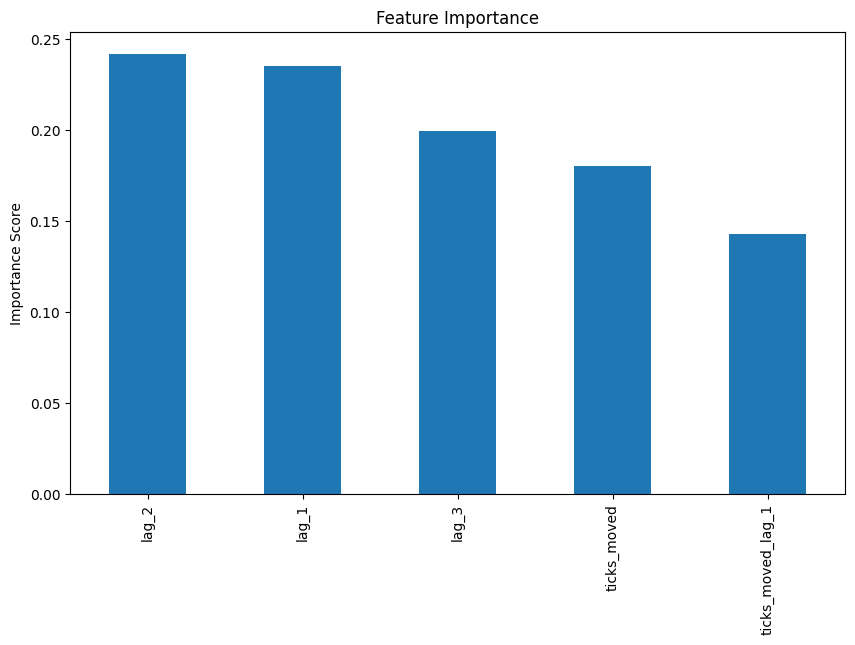

In [4]:
# Step 1: Load the dataset
year = "2023"
ccy = "gbpusd"
file_path = rf'{input_file_path}/{year}_{ccy}_tick_prev_price_as_base.csv'

# Convert datetime column to pandas datetime format
df = pd.read_csv(file_path)
df["datetime"] = pd.to_datetime(df["datetime"])

# Step 2: Feature Engineering
# Create lagged features for price
lags = [1, 2, 3]
for lag in lags:
    df[f'lag_{lag}'] = df['price'].shift(lag)

# Include `ticks_moved` as a feature and create lagged versions
df['ticks_moved_lag_1'] = df['ticks_moved'].shift(1)

# Drop rows with NaN (introduced by lagging)
df.dropna(inplace=True)

# Define features and target
features = [col for col in df.columns if col.startswith('lag') or 'ticks_moved' in col]
df['target'] = (df['directions'] > 0).astype(int)  # Binary target: 1 for up, 0 for down
X = df[features]
y = df['target']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

# Step 4: Train XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Step 5: Evaluate Model
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_text = classification_report(y_test, y_pred)

# Step 6: Analyze Feature Importance
feature_importance = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)

# Display Results
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report_text)
print("\nFeature Importance:\n", feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.show()


Backtesting

Parameters:

initial_balance: The starting capital for the backtest.
lot_size: The size of each trade (in units of the currency).
Logic:

A trade is placed based on the model's prediction:
If the model predicts "up" (1), we simulate a buy.
If the model predicts "down" (0), we simulate a sell.
Profit or loss is calculated based on whether the model's prediction aligns with the actual movement (y_test).
Trade Profit Calculation:

price * 0.0001 * lot_size is a simple approximation for pip movement profit/loss.
This assumes 1 pip = 0.0001 for most currency pairs (adjust as needed).
Outputs:

balance_history: The account balance over time.
trade_log: Detailed log of each trade, including tick, price, predicted and actual direction, profit, and updated balance.


In [5]:
def run_backtest(df, X_test, y_test, y_pred, initial_balance=10000, lot_size=1000):
    """
    Run a simple backtest using model predictions.

    Parameters:
    - df: DataFrame, the original data with features and target.
    - X_test: array, the test feature set.
    - y_test: array, the actual target values for the test set.
    - y_pred: array, the predicted target values for the test set.
    - initial_balance: float, the starting capital for backtesting.
    - lot_size: float, the trade size in units.

    Returns:
    - balance_history: list of balances over time.
    - trade_log: list of trades with details.
    """
    # Initialize variables
    balance = initial_balance
    balance_history = [balance]
    trade_log = []

    for i in range(len(y_pred)):
        actual = y_test.iloc[i]
        predicted = y_pred[i]
        price = df.iloc[len(df) - len(X_test) + i]['price']  # Match test index to df
        
        # Simulate a trade based on predicted direction
        if predicted == 1:  # Buy signal
            trade_profit = (price * 0.0001 * lot_size) if actual == 1 else -(price * 0.0001 * lot_size)
        else:  # Sell signal
            trade_profit = -(price * 0.0001 * lot_size) if actual == 1 else (price * 0.0001 * lot_size)

        # Update balance
        balance += trade_profit
        balance_history.append(balance)

        # Log trade
        trade_log.append({
            'tick': df.iloc[len(df) - len(X_test) + i]['tick_number'],
            'price': price,
            'predicted': predicted,
            'actual': actual,
            'profit': trade_profit,
            'balance': balance
        })

    return balance_history, trade_log


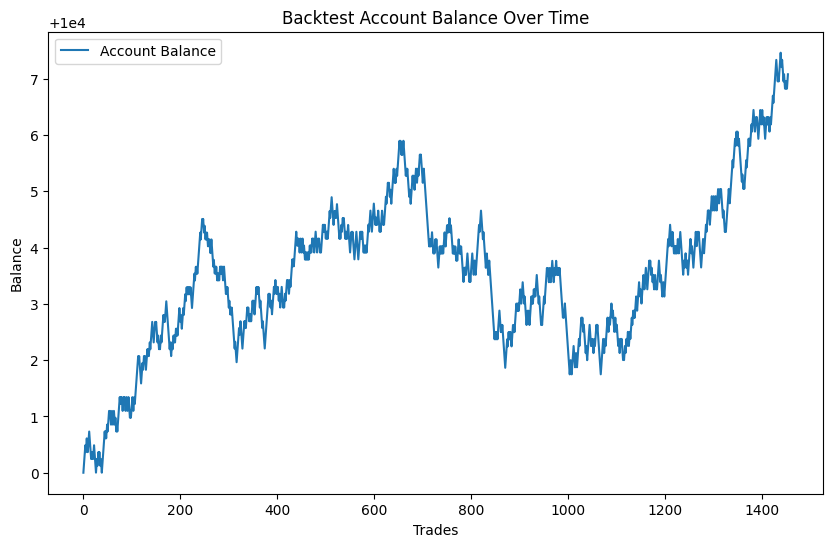

Test set size: 1453
      tick    price  predicted  actual    profit       balance
0     5813  1.21915          0       0  0.121915  10000.121915
1     5814  1.21815          0       0  0.121815  10000.243730
2     5815  1.21915          1       1  0.121915  10000.365645
3     5816  1.22015          1       1  0.122015  10000.487660
4     5817  1.21915          1       0 -0.121915  10000.365745
...    ...      ...        ...     ...       ...           ...
1448  7261  1.27515          1       0 -0.127515  10006.821825
1449  7262  1.27415          0       0  0.127415  10006.949240
1450  7263  1.27515          0       1 -0.127515  10006.821725
1451  7264  1.27415          0       0  0.127415  10006.949140
1452  7265  1.27315          0       0  0.127315  10007.076455

[1453 rows x 6 columns]


In [6]:
# Run backtest
balance_history, trade_log = run_backtest(df, X_test, y_test, y_pred)

# Convert trade_log to a DataFrame for easier analysis
trade_log_df = pd.DataFrame(trade_log)

# Plot balance history
plt.figure(figsize=(10, 6))
plt.plot(balance_history, label='Account Balance')
plt.title('Backtest Account Balance Over Time')
plt.xlabel('Trades')
plt.ylabel('Balance')
plt.legend()
plt.show()

print(f"Test set size: {len(X_test)}")

# Display trade log
print(trade_log_df)

